## Visualizing results -  Original Geoparser

We have run the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to extract and resolvoe locations contained within the **First Edition, Volume 1, A-B** (year 1771) of the *Encyclopaedia Britannica*, which has 832 pages.
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_subsample.txt nls defoe.nls.queries.geoparser_pages -r geopaser_original_EB_144133901 -n 16`

The nls_subsample.txt has the path of this particular book that we are exploring:

`xxx/nls-data-encyclopaediaBritannica/144133901`

The results file ( [geopaser_original_EB_144133901](http://localhost:8888/edit/results_NLS/geopaser_original_EB_144133901)) is stored in this repository under the *results_NLS* subdirectory. 


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations):
    place_label=[]
    place_freq = []
    for i in range(0,15):
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        print(i, place_count,place_name)
        place_label.append(place_name)
        place_freq.append(place_count)
    return place_label, place_freq

In [6]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq)
    plt.xlabel('Places', fontsize=10)
    plt.ylabel('Frequency of Places', fontsize=5)
    plt.xticks(index, place_label, fontsize=8, rotation=40)
    plt.title('15 Places most mentioned')
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original geotagging of the Edinburgh geoparser. 
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
    
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '57.68633318560074'
        - '-4.96890721218449'
  - lang_model: geoparser_original
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [7]:
results=read_query_results('geopaser_original_EB_144133901')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total.head(10)

,Latitude,Longitude,Place,Page
0,57.68633318560074,-4.96890721218449,SCOTLAND,Page9
1,40.66852,16.60158,Materia,Page12
2,45.27190104864457,-69.02811957460864,Me,Page12
3,33.62540263492369,-80.96431606708276,Carolina,Page13
4,27.77136719389102,-83.82959337018778,Florida,Page13
5,53.69180622064813,-2.423529257645026,Scotland,Page13
6,34.8381384,-84.41853570000001,Bart,Page13
7,29.7891185,-95.82328440000001,James Stewart,Page14
8,35.67397,-94.07353999999999,Locke,Page14
9,40.12667,127.78139,Koran,Page14


In [10]:
df_total[["Place"]].count()

Place    5869
dtype: int64

In [11]:
df_total.sum()

Latitude     57.6863331856007440.6685245.2719010486445733.6...
Longitude    -4.9689072121844916.60158-69.02811957460864-80...
Place        SCOTLANDMateriaMeCarolinaFloridaScotlandBartJa...
Page         Page9Page12Page12Page13Page13Page13Page13Page1...
dtype: object

In [12]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
AACH,1,1,1
AADE,1,1,1
ABACA,1,1,1
ABACH,1,1,1
ABACO,1,1,1
ABADAN,1,1,1
ABADIR,1,1,1
ABAI,1,1,1
ABANCAI,1,1,1


In [13]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page100,9,9,9
Page101,42,42,42
Page102,27,27,27
Page103,39,39,39
Page104,27,27,27
Page105,36,36,36
Page106,43,43,43
Page109,23,23,23
Page110,24,24,24


In [14]:
df_total.groupby(["Latitude", "Longitude"]).count()

,,Place,Page
Latitude,Longitude,,
,,274,274
-0.1366818175840478,100.6383162769587,2,2
-0.1544928803232608,-78.44005994797827,1,1
-0.2333333,-78.33333330000001,1,1
-1.0753,121.7811,1,1
-1.15,17.3333333,1,1
-1.380613091643525,-48.41852484800316,1,1
-1.445725396559766,5.629326002193295,1,1
-10.5075,-76.5333333,1,1


In [15]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

# removing the first forw
df_max_geolocations=df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(10)


,Latitude,Longitude,count
1723,50.6522111706725,-3.615645583175173,186
1782,51.16809234634502,10.43727461748782,105
2114,54.31925079960345,-2.232838508197517,95
2233,59.22022125858783,25.35590660898998,89
1986,52.66970530850324,-1.117070990383866,76
153,10.65684336992561,-61.52036078532194,75
1352,45.2425296081972,-94.88857066304371,73
954,41.28723551456983,12.56034916155997,68
2082,53.69180622064813,-2.423529257645026,57
902,40.91260214947856,14.18904860186132,52


In [16]:
# Getting the geolocation details of the max frequency (50.6522111706725 	-3.615645583175173)
place_count, place_name= get_place(df_total, '50.6522111706725', '-3.615645583175173')
place_count, place_name

(186, 'France')

In [17]:
#Getting the 15 places (and their frequencies) most mentioned
place_label, place_freq = label_freq_places(df_total, df_max_geolocations)
    

0 186 France
1 105 Germany
2 95 Britain
3 89 Europe
4 76 England
5 75 Spain
6 73 America
7 68 Italy
8 57 Scotland
9 52 Naples
10 50 Rome
11 47 America
12 46 London
13 44 India
14 42 Africa


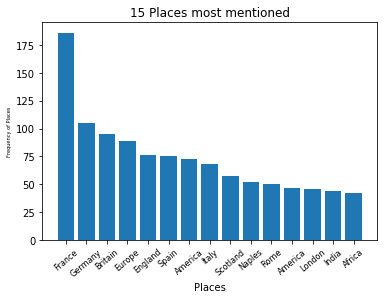

In [18]:
#Visualizing the 15 places in a Bar plot
plot_bar_places(place_label, place_freq)